## REFERENCES
#### time-series w/ DL: github repos
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
* https://github.com/AMDonati/Deep-Learning-in-Time-Series
* https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data - **THE REFERENCE**
#### From machine learning mastery
* https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
#### time-series w/ DL on EHR data
* https://github.com/AMDonati/Deep-Neural-Networks-HealthCare/tree/master/Project%209%20--%20Deep%20Learning%20RNN%20for%20Predicting%20%20Glucose%20Concentration%20for%20Diabetes1%20Patients
* https://github.com/AMDonati/doctorai
#### Kaggle Kernels
* https://www.kaggle.com/c/web-traffic-time-series-forecasting

**NB: for time-series classification, CNNs can be used as well.**. See article: 
https://arxiv.org/pdf/1701.01887.pdf

**This library DeepTimeSeries can be useful:**  
https://github.com/pipidog/DeepTimeSeries

## PROBLEM DEFINITION

* forecast (categorical values) of multiple multi-step multivariate time-series of different lengths. 
* similar problem as the Kaggle competition: web traffic time series forecasting, the main differences being: 
 > the time-series sequence is much smaller in my case  
 > The different time-series of my problem are of different length (_but this could be changed by filling missing visits observations with the nearest neighbour_)
* This is a sequence to sequence prediction: prediction of a sequence of PD scale from an historical sequence. 
* Beyond LSTM, Seq2seq models could be the best. 
* At the end, the problem is very similar to generating an ordered sequence of words from a previous ordered sequence of words with a very reduced word dictionnary (equal to all the values of my categorical variables).
> the difference being that you have multiple variables to make this prediction and not only one (the word)...

### TO ASK TO TRISTAN
* Explanation of the problem with: 
    * dataset info
    * graphs
    * problematics
* LTSM / Seq2seq Good fit? 
* Do a unbalanced dataset will be an issue? 
* Any special tricks he foresee I could use for my problem (such as CNNs or Autoencoders before the RNNs as my features are quite correlated...)

### MODELS TO TEST
1. **Baseline - A non ML algo**: a classic satistical model (ARMA...), simply a discounted median...
2. _(if time)_ **Classic ML**: SVM, RF, XGBoost
3. **DL**: HMM, GRU/LTSM; Seq2seq; CNNs?
4. **Ensembling Models**

## FRAMEWORK
1. Data-processing
2. Plotting the data
3. Preparing the data for the ML algo:
    * data generator for multi-step multivariate time series forecast
    * Standardization/ normalisation? 
    * split train/val/test
4. Select and train the model
5. Model Evaluation: plot the results
    * Fine-tune the model (via GridSearch?)
    * Cross-validation
    * Metrics plotting

## 0. Imports & functions

In [1]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from datetime import datetime
 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

#paths
#PPMI_zippath='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/PPMI-final-dataset-382018.zip'
PPMI_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/data/'

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Code from F.Chollet on temperatures forecast

In [7]:
#Inspecting the data from Jena dataset
import os
data_dir='/Users/alicemartin/Downloads/jen_climate'
fname=os.path.join(data_dir,'jena_climate_2009_2016.csv')
f=open(fname)
data=f.read()
f.close()
lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]
print(header)
print(len(header))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420551


In [8]:
# converting the lines of data into a numpy array
import numpy as np
float_data=np.zeros((len(lines),len(header)-1))
for i, line in enumerate(lines): 
    values=[float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values  
#(equivalent to transform a dataframe into a numpy array)

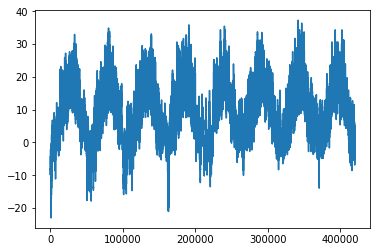

In [9]:
from matplotlib import pyplot as plt
temp=float_data[:,1]
plt.plot(range(len(temp)),temp)

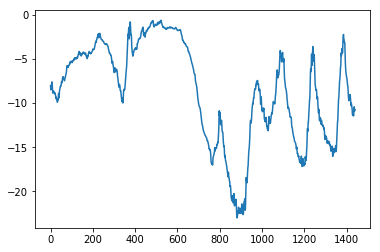

In [10]:
# First 10 days of the time series
plt.plot(range(1440),temp[:1440])

## 3-Preparing the data for the RNN

In [11]:
### Normalization
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
float_data[:1]

array([[ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
        -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
         2.12375056, -0.72950452, -0.78067973, -0.27613603]])

In [12]:
float_data.shape[-1] # number of features

14

In [13]:
## implementing generator
# lookback = 720 - observations will go back 5 days. 
# steps = 6: obervations will be sampled at one data point per hour. 
# delay= 144 - Targets will be 24 hours in the future. 

#min_index and max_index: indices in the data array that delimit which time-steps to draw from.
#(allows split between train/val/test sets)

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback # you start after the lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size) 
            # shuffling batch_size rows from [min_index + lookback, max_index]
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index)) # integers from i to min (i+ batch_bize, max_index)
            i += len(rows) # iteration on i: i=i+len(rows)

        samples = np.zeros((len(rows), # number of samples in the batch
                           lookback // step, # number of past datapoints considered to predict the future
                           data.shape[-1])) # number of features
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #takes the step of the lookback (i.e every 6th point of the lookback points)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1] # tha targets are the present + the delay. 
        yield samples, targets
        
# At a glance, the yield statement is used to define generators, 
#replacing the return of a function to provide a result to its caller without destroying local variables. 
#Unlike a function, where on each call it starts with new set of variables, 
#a generator will resume the execution where it was left off.

#The idea of generators is to calculate a series of results one-by-one on demand (on the fly).
#In the simplest case, a generator can be used as a list, where each element is calculated lazily.

In [14]:
### train/val/test split
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 4- Training w/ baselines. 

In [19]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


Epoch 1/5
50/50 [==============================] - 12s 239ms/step - loss: 3.3713 - val_loss: 2.8915
Epoch 2/5
50/50 [==============================] - 10s 210ms/step - loss: 2.6303 - val_loss: 2.7135
Epoch 3/5
50/50 [==============================] - 9s 185ms/step - loss: 2.3636 - val_loss: 2.2499
Epoch 4/5
50/50 [==============================] - 10s 198ms/step - loss: 2.0790 - val_loss: 1.8758
Epoch 5/5
50/50 [==============================] - 10s 205ms/step - loss: 1.9176 - val_loss: 1.5576


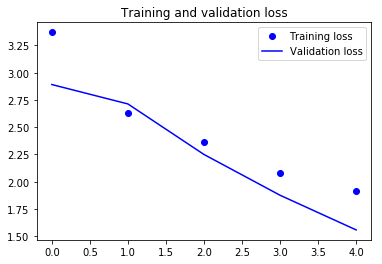

In [20]:
#### simple NN: 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
#input_shape= number of datapoints sampled, number of features)
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

epochs=5
steps_per_epoch=50

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps)

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 4-Training w a RNN

### first RNN. 

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps)
#### plotting results

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### adding dropout layers to prevent overfitting

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#### plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### stacking more layers

from keras.models import Sequential

from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

#### plotting the results. 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2. Machine Learning Mastery tutorial - Multivariate time-series forecasting with keras
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/  
**NB: this example is very similar as well**: https://github.com/amirrezaeian/Individual-household-electric-power-consumption-Data-Set-

In [31]:
# read the data
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('/Users/alicemartin/02_DSR_Project/github-repo-tutos/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


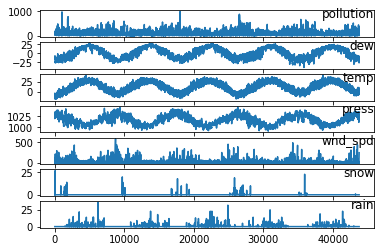

In [16]:
# plotting each sub-series
# load dataset
from matplotlib import pyplot
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Data preparation

In [17]:
# convert series to supervised learning: 
def series_to_supervised(data, n_in, n_out, dropnan=True): 
    n_vars=1 if type(data) is list else data.shape[1]
    df=pd.DataFrame(data)
    cols, names=list(), list()
    # input sequence (t-n,...,t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)'% (j+1,i)) for j in range(n_vars)]
    # forecast sequence (t,t+1,...,t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i==0:
            names+=[('var%d(t)'% (j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)'% (j+1,i)) for j in range(n_vars)]
    #put it all together
    agg=pd.concat(cols,axis=1)
    agg.columns=names
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True) # drop  var2(t), var3(t),var4(t)...
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


### Define and fit model

In [25]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


Train on 8760 samples, validate on 35039 samples
Epoch 1/10
 - 2s - loss: 0.0565 - val_loss: 0.0596
Epoch 2/10
 - 1s - loss: 0.0385 - val_loss: 0.0612
Epoch 3/10
 - 1s - loss: 0.0239 - val_loss: 0.0497
Epoch 4/10
 - 1s - loss: 0.0176 - val_loss: 0.0426
Epoch 5/10
 - 1s - loss: 0.0159 - val_loss: 0.0265
Epoch 6/10
 - 1s - loss: 0.0151 - val_loss: 0.0197
Epoch 7/10
 - 1s - loss: 0.0150 - val_loss: 0.0179
Epoch 8/10
 - 1s - loss: 0.0148 - val_loss: 0.0169
Epoch 9/10
 - 1s - loss: 0.0147 - val_loss: 0.0161
Epoch 10/10
 - 1s - loss: 0.0148 - val_loss: 0.0153


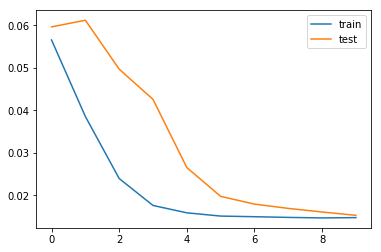

In [26]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
#Evaluate Model.
#make a prediction
yhat=model.predict(test_X)
test_X=test_X.reshape((test_X.shape[0],test_X.shape[2]))

#invert scaling for forecast
inv_yhat = pd.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = pd.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### 2.Bis: Machine Learning Mastery: Multistep time series forecast with LTSM

In [33]:
#'/Users/alicemartin/02_DSR_Project/github-repo-tutos/shampoo-sales.csv'

In [45]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
#series = read_csv('/Users/alicemartin/02_DSR_Project/github-repo-tutos/shampoo-sales.csv', 
                  #header=0, parse_dates=[0], index_col=0, squeeze=True, 
                  #error_bad_lines=True, date_parser=parser)
# summarize first few rows
#print(series.head())
# line plot
#series.plot()
#pyplot.show()

### Full code

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): 
    #n_in: number of input considered for forecast
    #n_out: number of timesteps to be forecasted. 
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# create a differenced series to HAVE STATIONARY DATA. 
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1) # TRANSFORM THE SERIE IN A DATAFRAME
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1)) # SCALING/ NORMALISATION
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1) # TRANSFORM SERIE INTO A DATAFRAME
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:] # split train/test sets
	return scaler, train, test
 
# fit an LSTM network to training data 
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons): # returns a fit LTSM model ready to be forecasted.
    #n_batch is the batch size (=1 here: online training)
    
	# reshape training into [samples, timesteps, features] 
    # split between features & labels.
	X, y = train[:, 0:n_lag], train[:, n_lag:]
    # X is the equivalent of the features (historic time-periods), 
    #y is the equivalent of the label (next time periods of the dataset)
	X = X.reshape(X.shape[0], 1, X.shape[1]) # - here timesteps=1
    
	# 1. DESIGN NETWORK
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    # the input shape is 3D: (number of  rows in training set, timestep (=1 here), number of features)
	model.add(Dense(y.shape[1])) #output layer of size: number of time periods to be predicted: len(n_batch:)
    
    # 2. COMPILE NETWORK
	model.compile(loss='mean_squared_error', optimizer='adam')
    
	# 3.FIT NETWORK
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

### _TO UNDERSTAND STARTING FROM THIS PART_

In [ ]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X)) # reshape of the data into a 3D-array. 
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model=BASELINE MODEL using one forecast from the lstm. 
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts
 
# invert differenced forecast - RETURN TO THE ORIGINAL DATASET SCALE(without difference between timestamps)
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts - FIT INVERTING THE SCALE ON EACH FORECAST 
#AND THEN INVERTING THE DIFFERENCE.
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted
 
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()
 
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 1500
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)

## 3. Github repo for web page traffic prediction problem (Kaggle/Wikipedia)
* http://localhost:8888/tree/02_DSR_Project/github-repo-tutos/Neural-Network-with-Financial-Time-Series-Data
* paper: https://arxiv.org/pdf/1710.04373.pdf